# Dataset conll04

This dataset is constructed from news articles and has 

In [10]:
import sys
sys.path.insert(0,'..')
import json
from abc import abstractmethod, ABC
from collections import OrderedDict
from logging import Logger
from typing import List
from tqdm import tqdm
from transformers import BertTokenizer

from spert import util
from spert.entities import Dataset, EntityType, RelationType, Entity, Relation, Document
from spert.opt import spacy
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


## Entities and Relation Types
Both types are in file `conll04_types.json` and can be extracted as follows: 

In [21]:

types_path = "../data/datasets/conll04/conll04_types.json"

types = json.load(open(types_path), object_pairs_hook=OrderedDict)
entity_types = pd.DataFrame(types['entities']).transpose()
relation_types = pd.DataFrame(types['relations']).transpose()

relation_types

,short,verbose,symmetric
Work_For,Work,Work for,False
Kill,Kill,Kill,False
OrgBased_In,OrgBI,Organization based in,False
Live_In,Live,Live in,False
Located_In,LocIn,Located in,False


In [3]:
entity_types

,short,verbose
Loc,Loc,Location
Org,Org,Organization
Peop,Peop,People
Other,Other,Other


## Data Splits

The data are pre-split into train, train-dev, 

In [47]:
paths = ["../data/datasets/conll04/conll04_train.json",
         #"../data/datasets/conll04/conll04_train_dev.json",
         "../data/datasets/conll04/conll04_dev.json",
         "../data/datasets/conll04/conll04_test.json"]
#labels = ["train","train_dev","dev","test"]
labels = ["train","dev","test"]
data_splits = {}
for pth, label in zip(paths,labels):
    data_splits[label] = json.load(open(pth), object_pairs_hook=OrderedDict)
data_splits.keys()


dict_keys(['train', 'dev', 'test'])

In [48]:
ex1 = data_splits['test'][100]
print("Each example contains:",ex1.keys())
print('Tokens:', ex1['tokens'])
print()
print('Entities:')
print(pd.DataFrame(ex1['entities']))
print()
print('Relations:')
print(ex1['relations'])
print()
print('original id:', ex1['orig_id'])



Each example contains: odict_keys(['tokens', 'entities', 'relations', 'orig_id'])
Tokens: ['The', 'DEM', 'outlawed', 'plastic', 'ducks', 'in', 'Rhode', 'Island', 'waterways', 'after', 'a', 'race', 'in', 'Warwick', 'sent', '7', ',', '000', 'toy', 'ducks', 'floating', 'down', 'the', 'Pawtuxet', 'River.']

Entities:
  type  start  end
0  Loc      6    8
1  Loc     13   14
2  Loc     23   25

Relations:
[OrderedDict([('type', 'Located_In'), ('head', 1), ('tail', 0)]), OrderedDict([('type', 'Located_In'), ('head', 2), ('tail', 0)]), OrderedDict([('type', 'Located_In'), ('head', 2), ('tail', 1)])]

original id: 1996


The train-dev set is the union of train and dev as shown below:

In [49]:
[ "%s has %i examples"%(l,len(s)) for l,s in data_splits.items()]

['train has 922 examples', 'dev has 231 examples', 'test has 288 examples']

The size  of each train-dev example measured as token count:
 

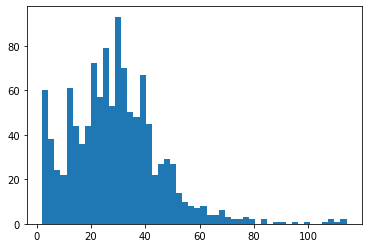

In [50]:
sizes = [len(ex['tokens']) for  ex in data_splits['train']+data_splits['dev'] ]
plot_bins = plt.hist(sizes, bins=50)
#plot_bins

In [51]:
for split in data_splits:
    print()
    print('Split',split)
    mentions = [ en['type'] for ex in data_splits[split] for en in ex['entities']]
    etypes = set(mentions)
    for et in etypes:
        print('entity type %s has %d mentions'%(et, sum([1 for m in mentions if m == et])))



Split train
entity type Other has 455 mentions
entity type Org has 616 mentions
entity type Loc has 1219 mentions
entity type Peop has 1087 mentions

Split dev
entity type Other has 118 mentions
entity type Org has 170 mentions
entity type Peop has 283 mentions
entity type Loc has 322 mentions

Split test
entity type Other has 133 mentions
entity type Org has 198 mentions
entity type Peop has 321 mentions
entity type Loc has 427 mentions


# The ADE Corpus

The ADE corpus was created by Gurulingappa, Harsha et al. described in their paper “Development of a benchmark corpus to support the automatic extraction of drug-related adverse effects from medical case reports.” published in the Journal of biomedical informatics vol. 45,5 (2012): 885-92. doi:10.1016/j.jbi.2012.04.008.

It is divided into three parts: 

1.  DRUG-AE.rel provides relations between drugs and adverse effects, 
1.  DRUG-DOSE.rel provides relations between drugs and dosages and 
1.  ADE-NEG.txt provides all sentences in the ADE corpus that DO NOT contain any drug-related adverse effects.

The datasets are in English language text format.
The dataset used here is divided into 10 training and 10 test folds 

In [52]:
ada_train_paths = ["../data/datasets/ade/ade_split_%i_train.json"%i for i in range(9)]
ada_test_paths = ["../data/datasets/ade/ade_split_%i_test.json"%i for i in range(9)]
ada_types_path = "../data/datasets/ade/ade_types.json"
ada_types = json.load(open(ada_types_path), object_pairs_hook=OrderedDict)

ada_types


OrderedDict([('entities',
              OrderedDict([('Adverse-Effect',
                            OrderedDict([('short', 'AE'),
                                         ('verbose', 'Adverse-Effect')])),
                           ('Drug',
                            OrderedDict([('short', 'Drug'),
                                         ('verbose', 'Drug')]))])),
             ('relations',
              OrderedDict([('Adverse-Effect',
                            OrderedDict([('short', 'AE'),
                                         ('verbose', 'Adverse-Effect'),
                                         ('symmetric', False)]))]))])

In [53]:
ada_train_folds = [ 
    json.load(open(path))
    for path in ada_train_paths
]

The 10 folds have the same number of examples

In [54]:
[len(fold) for fold in ada_train_folds]

[3845, 3845, 3845, 3845, 3845, 3845, 3845, 3845, 3845]

Let's look at the 100th example from fold 7

In [55]:
ex=ada_train_folds[7][100]
print('Tokens:',ex['tokens'])
print('Entities:', ex['entities'])
print('Relations',ex['relations'])
print('orig_id:',ex['orig_id'])

Tokens: ['A', '67-year', '-', 'old', 'man', 'developed', 'diarrhea', 'shortly', 'after', 'a', '10-day', 'course', 'of', 'oral', 'ampicillin', '.']
Entities: [{'type': 'Adverse-Effect', 'start': 6, 'end': 7}, {'type': 'Drug', 'start': 14, 'end': 15}]
Relations [{'type': 'Adverse-Effect', 'head': 0, 'tail': 1}]
orig_id: 3307


The length distribution in tokens across all combined training examples:

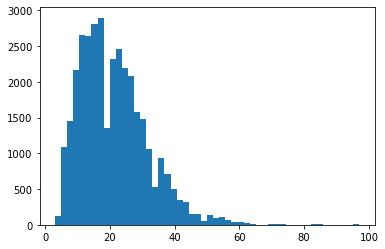

In [56]:
sizes = [len(ex['tokens']) for fold in ada_train_folds for  ex in fold ]
plot_bins = plt.hist(sizes, bins=50)
#plot_bins

In [57]:

sci_types_path = "../data/datasets/scierc/scierc_types.json"

sci_types = json.load(open(sci_types_path), object_pairs_hook=OrderedDict)
sci_entity_types = pd.DataFrame(sci_types['entities']).transpose()
sci_relation_types = pd.DataFrame(sci_types['relations']).transpose()


# The sciERC Corpus

The sciERC corpus  consists of text extracted from 500 AI abstracts. The dataset includes six entity types and seven relationship types shown below, and it includes 2687 sentences split into 1861 for traing, 275 for development evaluation and 551 for testing.

It was developed by Yi Luan, Luheng He, Mari Ostendorf, and Hannaneh Hajishirzi (2018) in association with their paper: ``Multi-Task Identification of Entities, Relations, and Coreference for Scientific Knowledge Graph Construction"

In [58]:

sci_entity_types

,short,verbose
Task,Task,Task
Method,Method,Method
Material,Material,Material
OtherScientificTerm,OST,Other Scientific Term
Metric,Metric,Metric
Generic,Generic,Generic


In [59]:
sci_relation_types

,short,verbose,symmetric
Used-for,Used-for,Used-for,False
Feature-of,Feature-of,Feature-of,False
Hyponym-of,Hyponym-of,Hyponym-of,False
Evaluate-for,Evaluate-for,Evaluate-for,False
Part-of,Part-of,Part-of,False
Compare,Compare,Compare,True
Conjunction,Conjunction,Conjunction,True


In [60]:
paths = ["../data/datasets/scierc/scierc_train.json",
         "../data/datasets/scierc/scierc_dev.json",
         "../data/datasets/scierc/scierc_test.json"]
labels = ["train","dev","test"]
data_splits = {}
for pth, label in zip(paths,labels):
    data_splits[label] = json.load(open(pth), object_pairs_hook=OrderedDict)
data_splits.keys()


dict_keys(['train', 'dev', 'test'])

In [61]:
ex1 = data_splits['train'][105]
print("Each example contains:",ex1.keys())
print('Tokens:', ex1['tokens'])
print()
print('Entities:')
print(pd.DataFrame(ex1['entities']))
print()
print('Relations:')
print(ex1['relations'])
print()
print('original id:', ex1['orig_id'])



Each example contains: odict_keys(['tokens', 'entities', 'relations', 'orig_id'])
Tokens: ['We', 'have', 'recently', 'shown', 'that', 'the', 'fusion', 'of', 'measurement', 'information', 'with', 'system', 'dynamics', 'and', 'shape', 'priors', 'greatly', 'improves', 'the', 'tracking', 'performance', 'for', 'very', 'noisy', 'images', 'such', 'as', 'ultrasound', 'sequences', '[', '22', ']', '.']

Entities:
       type  start  end
0    Method      6   16
1      Task     19   20
2  Material     23   25
3  Material     27   29

Relations:
[OrderedDict([('type', 'Used-for'), ('head', 0), ('tail', 1)]), OrderedDict([('type', 'Used-for'), ('head', 1), ('tail', 2)]), OrderedDict([('type', 'Hyponym-of'), ('head', 3), ('tail', 2)])]

original id: c74808ce-f66b-457b-b94c-e5066fb571c9


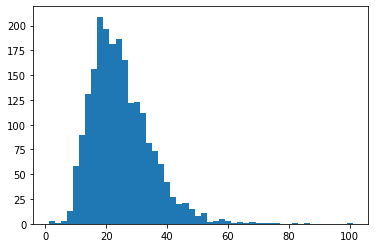

In [62]:
sizes = [len(ex['tokens']) for  ex in data_splits['train']+data_splits['dev'] ]
plot_bins = plt.hist(sizes, bins=50)
#plot_bins